This is a fun Halloween competition. We have some characteristics of monsters and the goal is to predict the type of monsters: ghouls, goblins or ghosts.

At first I do data exploration to get some insights. Then I try various models for prediction. The final prediction is done with the help of ensemble and majority voting

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import GaussianNB

In [2]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371 entries, 0 to 370
Data columns (total 7 columns):
id               371 non-null int64
bone_length      371 non-null float64
rotting_flesh    371 non-null float64
hair_length      371 non-null float64
has_soul         371 non-null float64
color            371 non-null object
type             371 non-null object
dtypes: float64(4), int64(1), object(2)
memory usage: 20.4+ KB


In [4]:
train.describe(include='all')

,id,bone_length,rotting_flesh,hair_length,has_soul,color,type
count,371.000000,371.000000,371.000000,371.000000,371.000000,371,371
unique,NaN,NaN,NaN,NaN,NaN,6,3
top,NaN,NaN,NaN,NaN,NaN,white,Ghoul
freq,NaN,NaN,NaN,NaN,NaN,137,129
mean,443.676550,0.434160,0.506848,0.529114,0.471392,NaN,NaN
std,263.222489,0.132833,0.146358,0.169902,0.176129,NaN,NaN
min,0.000000,0.061032,0.095687,0.134600,0.009402,NaN,NaN
25%,205.500000,0.340006,0.414812,0.407428,0.348002,NaN,NaN
50%,458.000000,0.434891,0.501552,0.538642,0.466372,NaN,NaN
75%,678.500000,0.517223,0.603977,0.647244,0.600610,NaN,NaN


Numerical columns are either normalized or show a percentage, so no need to scale them.

In [5]:
train.head()

,id,bone_length,rotting_flesh,hair_length,has_soul,color,type
0,0,0.354512,0.350839,0.465761,0.781142,clear,Ghoul
1,1,0.575560,0.425868,0.531401,0.439899,green,Goblin
2,2,0.467875,0.354330,0.811616,0.791225,black,Ghoul
3,4,0.776652,0.508723,0.636766,0.884464,black,Ghoul
4,5,0.566117,0.875862,0.418594,0.636438,green,Ghost


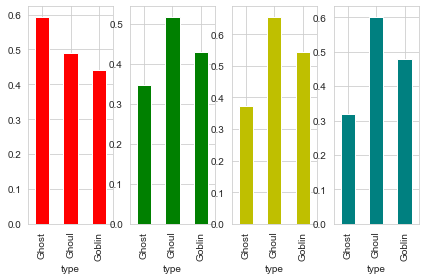

In [6]:
plt.subplot(1,4,1)
train.groupby('type').mean()['rotting_flesh'].plot(kind='bar',figsize=(7,4), color='r')
plt.subplot(1,4,2)
train.groupby('type').mean()['bone_length'].plot(kind='bar',figsize=(7,4), color='g')
plt.subplot(1,4,3)
train.groupby('type').mean()['hair_length'].plot(kind='bar',figsize=(7,4), color='y')
plt.subplot(1,4,4)
train.groupby('type').mean()['has_soul'].plot(kind='bar',figsize=(7,4), color='teal');

It seems that all numerical features may be useful

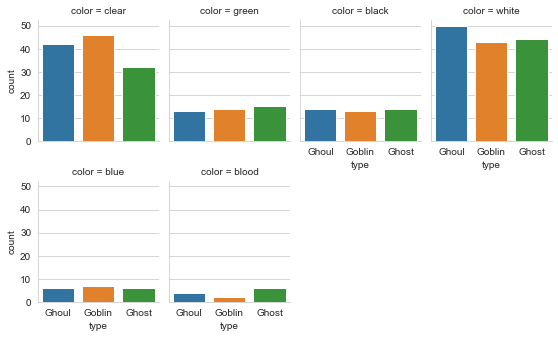

In [10]:
sns.catplot(x='type', col='color', data=train, kind='count', col_wrap=4, height=2.4, aspect=0.8);

Funny, but many colors are evenly distributes among the monsters. So they maybe nor very useful for analysis.



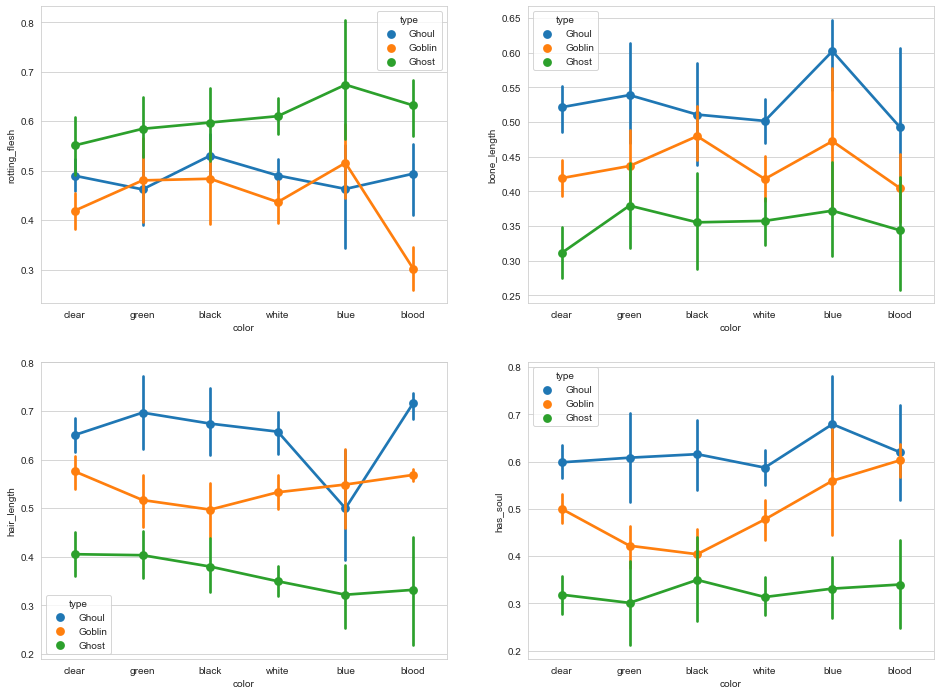

In [11]:
fig, ax = plt.subplots(2, 2, figsize = (16, 12))
sns.pointplot(x="color", y="rotting_flesh", hue="type", data=train, ax = ax[0, 0])
sns.pointplot(x="color", y="bone_length", hue="type", data=train, ax = ax[0, 1])
sns.pointplot(x="color", y="hair_length", hue="type", data=train, ax = ax[1, 0])
sns.pointplot(x="color", y="has_soul", hue="type", data=train, ax = ax[1, 1]);

In most cases color won't "help" other variables to improve accuracy.

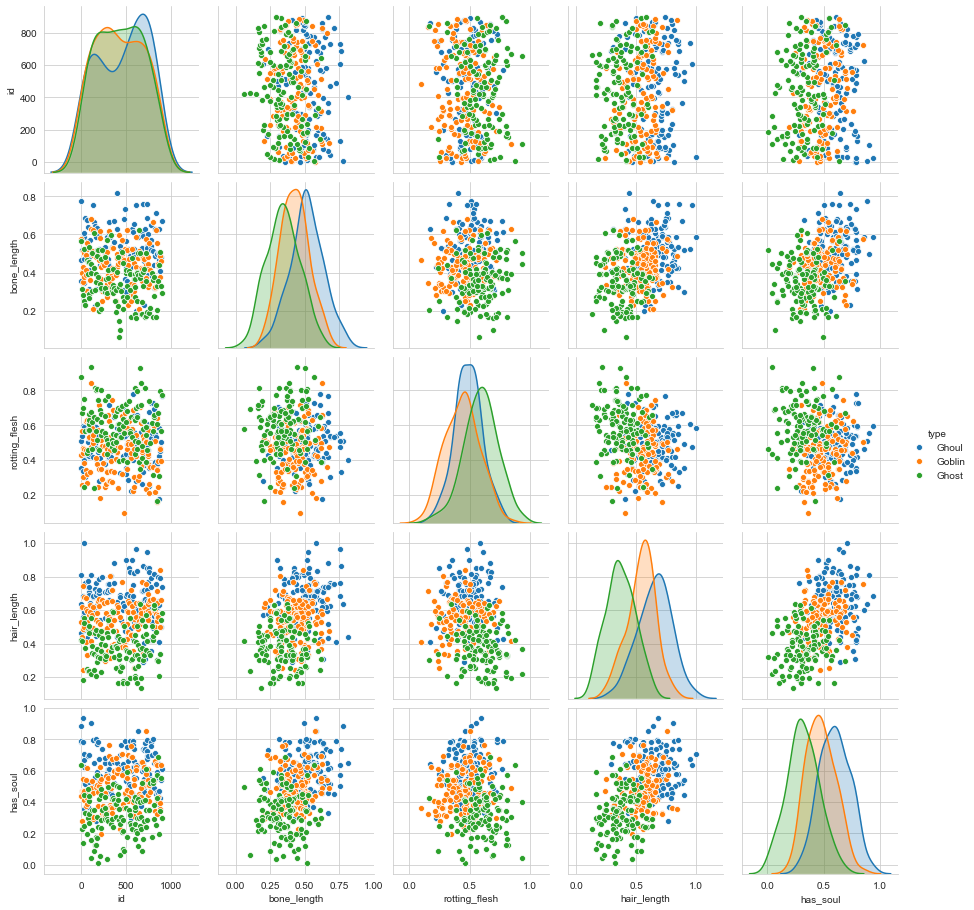

In [13]:
sns.pairplot(train, hue='type');

This pairplot shows that data is distributed normally. And while most pairs are widely scattered (in relationship to the type), some of them show clusters: hair_length and has_soul, hair_length and bone_length. I decided to create new variables with multiplication of these columns and it worked great!

## <font color='royalblue'>Data Preparation<font>

In [15]:
train['hair_soul'] = train['hair_length'] * train['has_soul']
train['hair_bone'] = train['hair_length'] * train['bone_length']
test['hair_soul'] = test['hair_length'] * test['has_soul']
test['hair_bone'] = test['hair_length'] * test['bone_length']
train['hair_soul_bone'] = train['hair_length'] * train['has_soul'] * train['bone_length']
test['hair_soul_bone'] = test['hair_length'] * test['has_soul'] * test['bone_length']

In [16]:
#test_id will be used later, so save it
test_id = test['id']
train.drop(['id'], axis=1, inplace=True)
test.drop(['id'], axis=1, inplace=True)

In [17]:
col = 'color'
dummies = pd.get_dummies(train[col], drop_first=False)
dummies = dummies.add_prefix("{}_".format(col))
train.drop(col, axis=1, inplace=True)
train = train.join(dummies)
dummies = pd.get_dummies(test[col], drop_first=False)
dummies = dummies.add_prefix("{}_".format(col))
test.drop(col, axis=1, inplace=True)
test = test.join(dummies)

In [19]:
X_train = train.drop('type', axis=1)
le = LabelEncoder()
Y_train = le.fit_transform(train.type.values)
X_test = test

In [23]:
clf = RandomForestClassifier(n_estimators=200).fit(X_train, Y_train)
indices = np.argsort(clf.feature_importances_)[::-1]
print('Feature Ranking:')
for f in range(X_train.shape[1]):
    print('{}. feature {} {} ({})'.format(f+1, indices[f], X_train.columns[indices[f]], clf.feature_importances_[indices[f]]))

Feature Ranking:
1. feature 6 hair_soul_bone (0.2029326755225338)
2. feature 4 hair_soul (0.16162974388543672)
3. feature 5 hair_bone (0.13639529256055924)
4. feature 2 hair_length (0.12798728779738358)
5. feature 3 has_soul (0.12300348090487166)
6. feature 1 rotting_flesh (0.12220171975061753)
7. feature 0 bone_length (0.0843412809452566)
8. feature 10 color_clear (0.010751253130998482)
9. feature 12 color_white (0.008439767685768217)
10. feature 11 color_green (0.0070698983419707154)
11. feature 9 color_blue (0.0069259202148604345)
12. feature 7 color_black (0.006034074610151452)
13. feature 8 color_blood (0.0022876046495916504)


Graphs and model show that color has little impact, so I won't use it. In fact I tried using it, but the result got worse. And three features, which I created, seem to be important!

In [24]:
best_features = X_train.columns[indices[0:7]]
X = X_train[best_features]
Xt = X_test[best_features]

## <font color='royalblue'>Model<font>

In [25]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, Y_train, test_size=0.20, random_state=42)

Tune the model. Normally you input all parameters and their potential values and run GridSearchCV. My PC isn't good enough so I divide parameters in two groups and repeatedly run two GridSearchCV until I'm satisfied with the result. This gives a balance between the quality and the speed.

In [31]:
forest = RandomForestClassifier(max_depth = 100,                                
                                min_samples_split =2,
                                min_weight_fraction_leaf = 0.0,
                                max_leaf_nodes = 40)

parameter_grid = {'n_estimators' : [10, 20, 150],
                  'criterion' : ['gini', 'entropy'],
                  'max_features' : ['auto', 'sqrt', 'log2']
                 }

grid_search = GridSearchCV(forest, param_grid=parameter_grid, scoring='accuracy', cv=StratifiedKFold(5))
grid_search.fit(X, Y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.7223423423423423
Best parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 20}


In [33]:
forest = RandomForestClassifier(n_estimators = 20,
                                criterion = 'entropy',
                                max_features = 'sqrt')
parameter_grid = {
                  'max_depth' : [None, 5, 100],
                  'min_samples_split' : [2, 5, 7],
                  'min_weight_fraction_leaf' : [0.0, 0.1],
                  'max_leaf_nodes' : [40, 80],
                 }

grid_search = GridSearchCV(forest, param_grid=parameter_grid, scoring='accuracy', cv=StratifiedKFold(5))
grid_search.fit(X, Y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.733081081081081
Best parameters: {'max_depth': None, 'max_leaf_nodes': 80, 'min_samples_split': 7, 'min_weight_fraction_leaf': 0.0}


Calibrated classifier gives probabilities for each class, so to check the accuracy at first I chose the most probable class and convert it to values. Then I compare it to values of validation set.

In [35]:
clf = RandomForestClassifier(n_estimators=20, n_jobs=-1, criterion = 'entropy', max_features = 'sqrt',
                             min_samples_split=7, min_weight_fraction_leaf=0.0,
                             max_leaf_nodes=80, max_depth=None)

calibrated_clf = CalibratedClassifierCV(clf, method='sigmoid', cv=5)
calibrated_clf.fit(Xtrain, ytrain)
y_val = calibrated_clf.predict_proba(Xtest)

print("Validation accuracy: ", sum(pd.DataFrame(y_val, columns=le.classes_).idxmax(axis=1).values
                                   == le.inverse_transform(ytest))/len(ytest))

Validation accuracy:  0.72


I used the best parameters and validation accuracy is ~72%. Not bad. But let's try something else.

In [38]:
svc = svm.SVC(kernel='linear')
svc.fit(Xtrain, ytrain)
y_val_s = svc.predict(Xtest)
print("Validation accuracy: ", sum(le.inverse_transform(y_val_s) == le.inverse_transform(ytest))/len(ytest))

Validation accuracy:  0.68


In [44]:
#The last model is logistic regression
logreg = LogisticRegression(max_iter=400)

parameter_grid = {'solver' : ['newton-cg', 'lbfgs'],
                  'multi_class' : ['ovr', 'multinomial'],
                  'C' : [0.005, 0.01, 1, 10, 100, 1000],
                  'tol': [0.0001, 0.001, 0.005]
                 }

grid_search = GridSearchCV(logreg, param_grid=parameter_grid, cv=StratifiedKFold(5))
grid_search.fit(Xtrain, ytrain)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.7699999999999999
Best parameters: {'C': 1000, 'multi_class': 'ovr', 'solver': 'newton-cg', 'tol': 0.0001}


In [46]:
log_reg = LogisticRegression(C = 1000, tol = 0.0001, solver='newton-cg', multi_class='ovr')
log_reg.fit(Xtrain, ytrain)
y_val_l = log_reg.predict_proba(Xtest)
print("Validation accuracy: ", sum(pd.DataFrame(y_val_l, columns=le.classes_).idxmax(axis=1).values
                                   == le.inverse_transform(ytest))/len(ytest))

Validation accuracy:  0.68


And then I received an advice to try ensemble or voting. Let's see.

Voting can be done manually or with sklearn classifier. For manual voting I need to make predictions for each classifier and to take the most common one. Advantage is that I may use any classifier I want, disadvantage is that I need to do it manually. Also, if some classifiers give predictions as classed and others as probability distribution, it complicates things. Or I can use sklearn.ensemble.VotingClassifier. Advantage is that it is easier to use. Disadvantage is that it may use only sklearn algorithms (or more precisely - algorithms with method "get_param") and only those which can give probability predictions (so no SVC and XGBooost).

In [47]:
clf = RandomForestClassifier(n_estimators=20, n_jobs=-1, criterion = 'entropy', max_features = 'sqrt',
                             min_samples_split=7, min_weight_fraction_leaf=0.0,
                             max_leaf_nodes=80, max_depth=None)

calibrated_clf = CalibratedClassifierCV(clf, method='sigmoid', cv=5)
log_reg = LogisticRegression(C = 1000, tol = 0.0001, solver='newton-cg', multi_class='ovr')
gnb = GaussianNB()

In [51]:
calibrated_clf1 = CalibratedClassifierCV(RandomForestClassifier())
log_reg1 = LogisticRegression()
gnb1 = GaussianNB()

As far as I can understand, while using hard voting, it is better to used unfitted estimators. Hard voting uses predicted class labels for majority rule voting. Soft voting predicts the class label based on the argmax of the sums of the predicted probalities, which is recommended for an ensemble of well-calibrated classifiers. And with soft voting we can use weights for models.

In [52]:
Vclf1 = VotingClassifier(estimators=[('LR', log_reg1), ('CRF', calibrated_clf1),
                                     ('GNB', gnb1)], voting='hard')
Vclf = VotingClassifier(estimators=[('LR', log_reg), ('CRF', calibrated_clf),
                                     ('GNB', gnb)], voting='soft', weights=[1,1,1])

In [53]:
hard_predict = le.inverse_transform(Vclf1.fit(X, Y_train).predict(Xt))
soft_predict = le.inverse_transform(Vclf.fit(X, Y_train).predict(Xt))

In [54]:
#Let's see the differences:
for i in range(len(hard_predict)):
    if hard_predict[i] != soft_predict[i]:
        print(i, hard_predict[i], soft_predict[i])

3 Ghost Goblin
40 Goblin Ghost
71 Ghost Goblin
96 Goblin Ghost
99 Goblin Ghost
100 Goblin Ghoul
111 Goblin Ghost
152 Ghoul Goblin
211 Ghost Goblin
253 Ghoul Goblin
254 Ghoul Goblin
273 Goblin Ghost
300 Goblin Ghoul
316 Goblin Ghost
338 Ghoul Goblin
380 Goblin Ghoul
383 Goblin Ghost
393 Goblin Ghost
394 Ghost Goblin
445 Ghoul Goblin
516 Ghoul Goblin


 I think that some ensemble of voting classifiers could improve score. For example use different classifiers for several VotingClassifiers and them make a majority voting on these VotingClassifiers.

In [55]:
submission = pd.DataFrame({'id':test_id, 'type':hard_predict})
submission.to_csv('GGG_submission.csv', index=False)